In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import celltypist

In [ ]:
# import session_info
# session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.set_figure_params(dpi=80)

# Variables

In [5]:
adata_dir = '/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/subsets'
sample_id = 'HEA_FOET14880396'
celltype = 'LymphoidCells'

In [6]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in data

In [7]:
# read in
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')
adata

AnnData object with n_obs × n_vars = 87 × 10288
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_1', 'leiden_1.2', 'leiden_1.5', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_coarse2midmod_colors', 'celltypist_coars

# Remove mid-grain markers from the feature

In [8]:
# read in
midgrain_markers = pd.read_csv('/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3/sc_midgrain_markers.csv',
                               index_col=0
                              )
# remove the markers of celltype of interest
midgrain_markers = midgrain_markers[midgrain_markers['group']!=celltype]
midgrain_markers.head()

group  names     scores  logfoldchanges  pvals  pvals_adj  \
0  AtrialCardiomyocytes   MYH6  589.18000        8.461190    0.0        0.0   
1  AtrialCardiomyocytes    PAM  446.76710        5.372062    0.0        0.0   
2  AtrialCardiomyocytes   NPPA  444.35940        7.048445    0.0        0.0   
3  AtrialCardiomyocytes   MYL7  444.03253        5.999820    0.0        0.0   
4  AtrialCardiomyocytes  TNNT2  428.84238        4.739163    0.0        0.0   

   group_mean  
0    3.555969  
1    4.026159  
2    4.366144  
3    4.489749  
4    3.264460

In [ ]:
'GATA2' in list(midgrain_markers['names'])

In [9]:
# remove
mask = [x not in list(midgrain_markers['names']) for x in adata.var_names]
bdata = adata[:,mask]
bdata

View of AnnData object with n_obs × n_vars = 87 × 9290
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_1', 'leiden_1.2', 'leiden_1.5', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_coarse2midmod_colors', 'celltypis

In [10]:
# remove cell cycle genes
cell_cycle_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
                'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
                'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8','HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67',
                'TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1',
                'CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF',
                'NEK2','G2E3','GAS2L3','CBX5','CENPA']
mask = [x not in cell_cycle_genes for x in bdata.var_names]
bdata = bdata[:,mask]
bdata.shape

(87, 9199)

In [ ]:
'MYH11' in list(bdata.var_names)

# PCA, Clustering, UMAP

number of hvgs: 2398


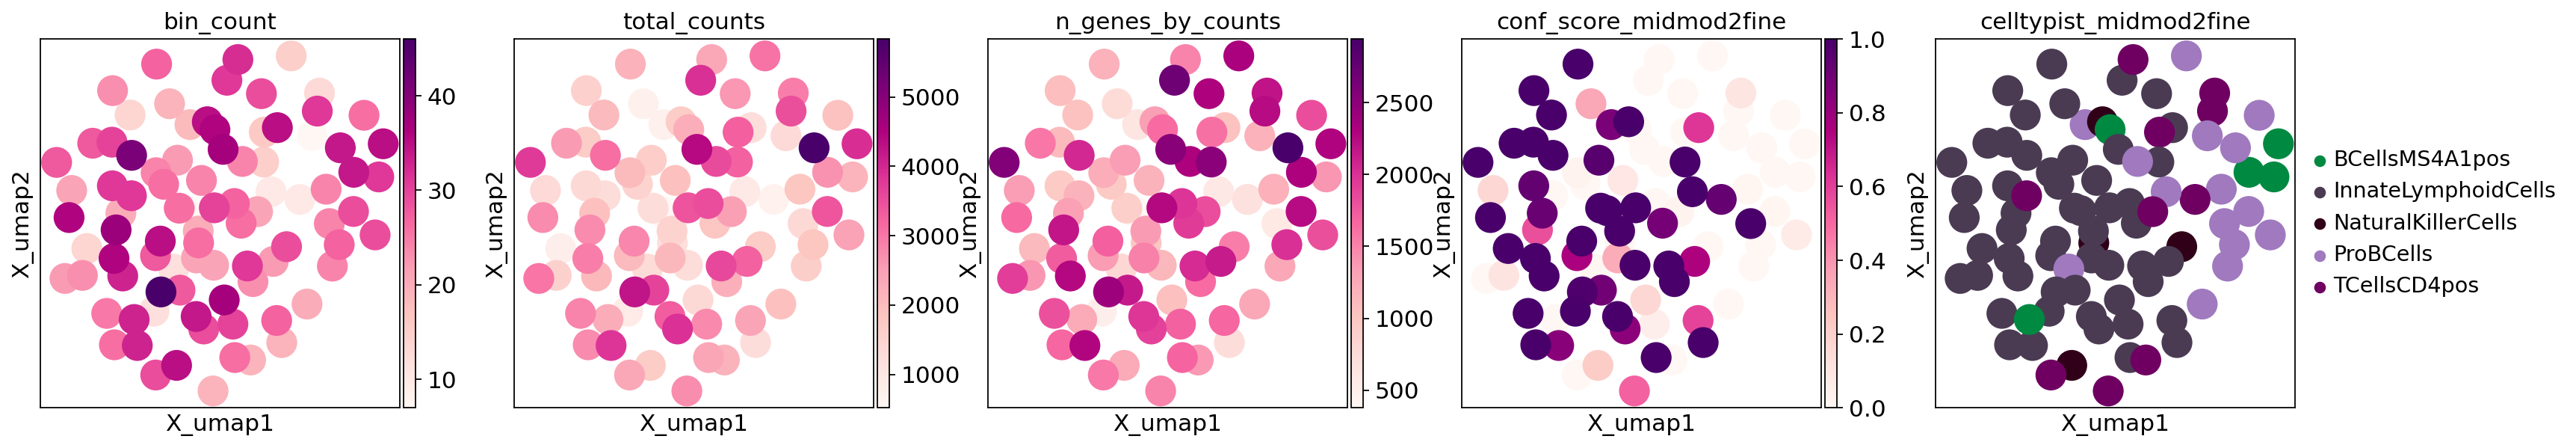

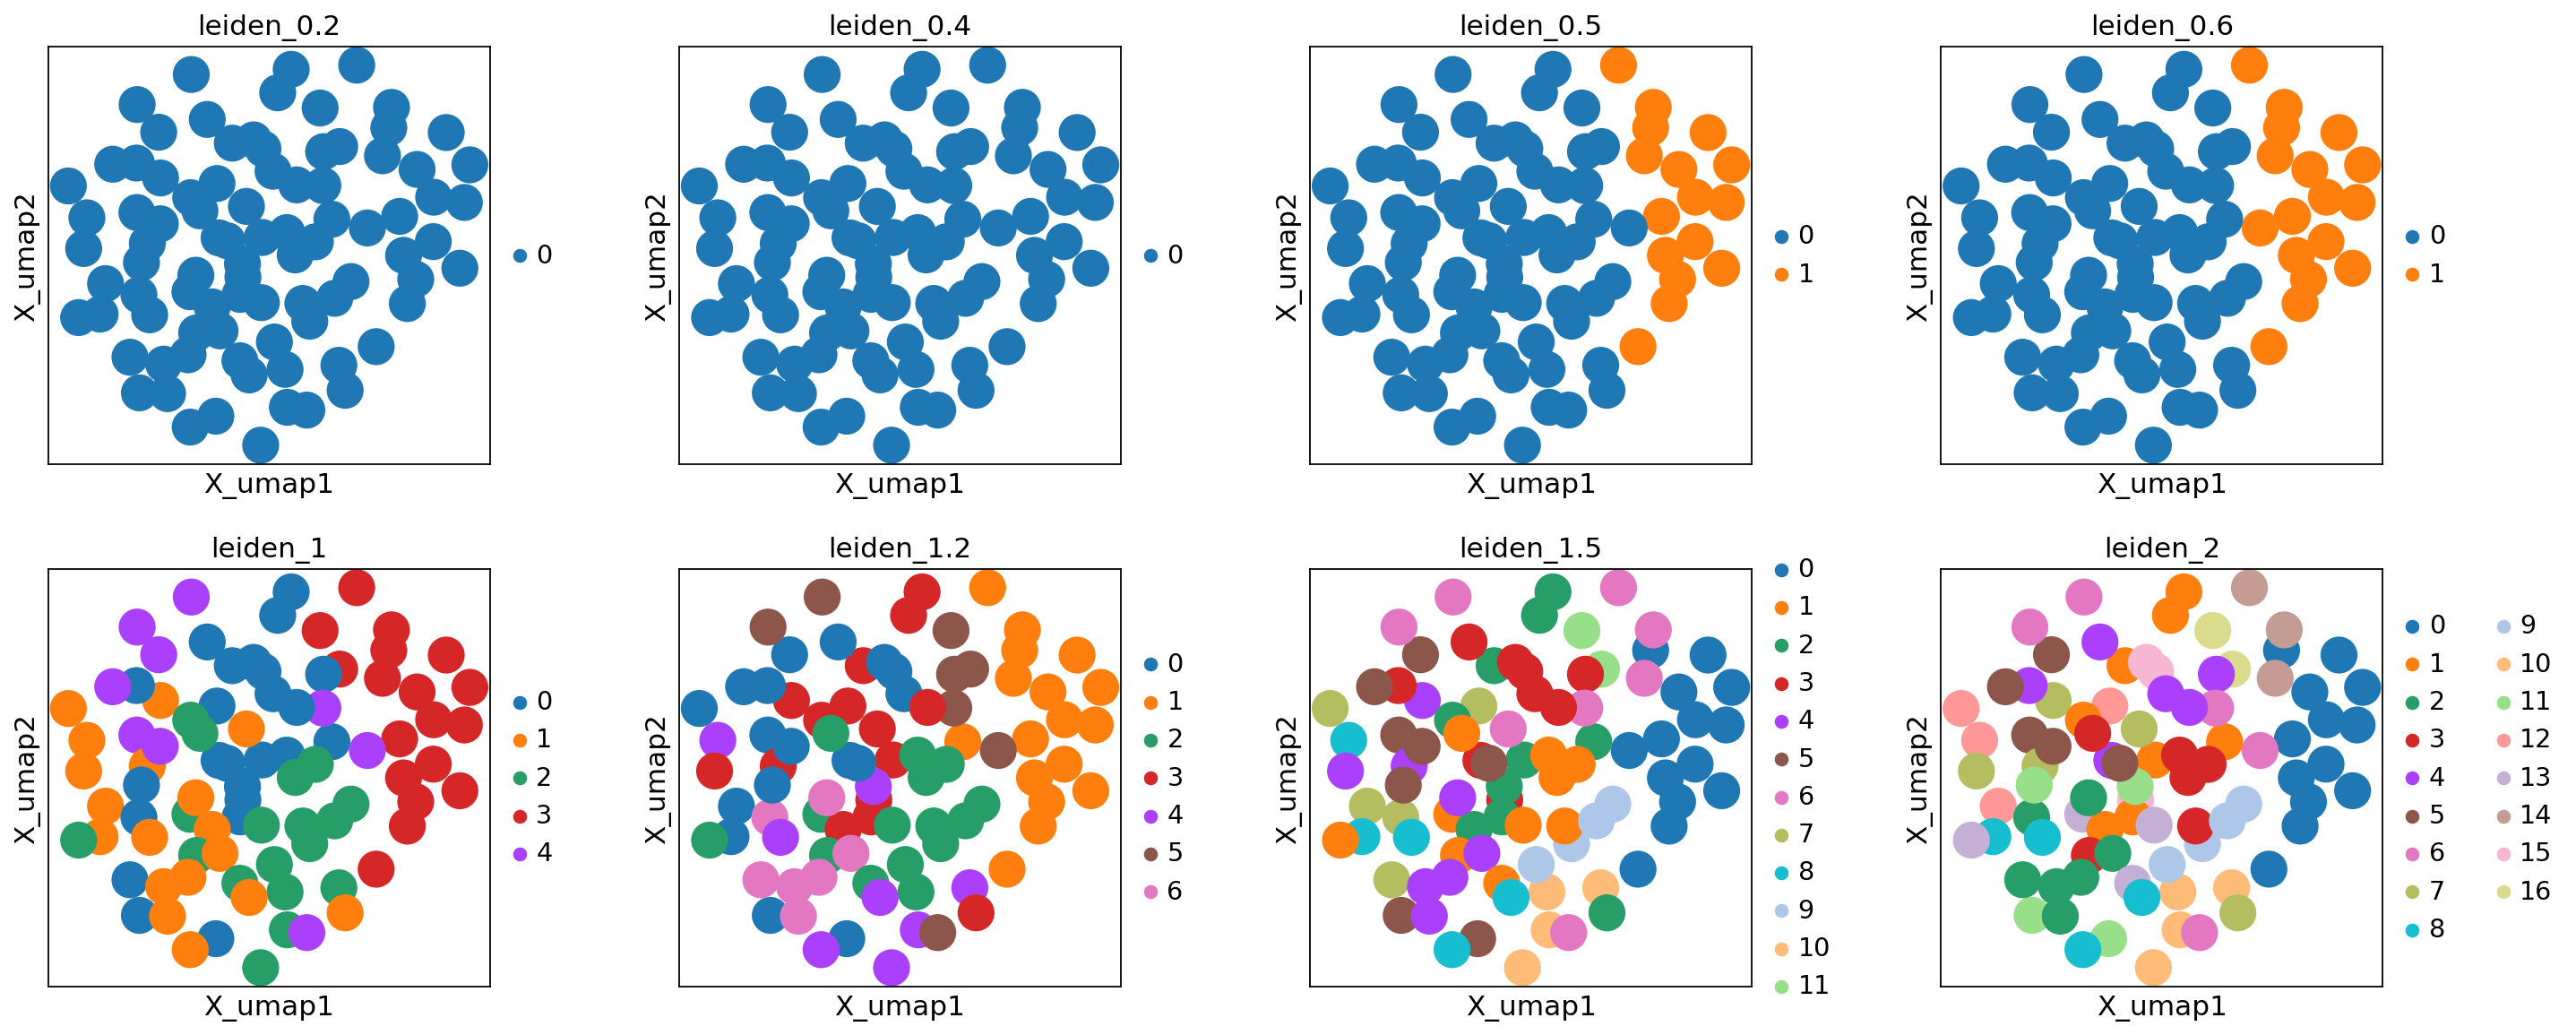

In [11]:
# HVGs, using the object which doesn't have midgrain markers
sc.pp.highly_variable_genes(bdata, flavor='seurat', min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f'number of hvgs: {sum(bdata.var.highly_variable)}')
# PCA using the degected HVGs
sc.tl.pca(bdata, use_highly_variable=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
# create neighbour graph
sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_pca')
# visualisation with umap
sc.tl.umap(adata,min_dist=0.5)
sc.pl.embedding(adata,basis='X_umap',color=['bin_count','total_counts','n_genes_by_counts',"conf_score_midmod2fine","celltypist_midmod2fine",],
                wspace=0.2,cmap='RdPu',vmax='p100',ncols=5)
# leiden clustering
resolutions_list = [0.2,0.4,0.5,0.6,1,1.2,1.5,2]
for resolution in resolutions_list:
    sc.tl.leiden(adata,resolution=resolution,key_added=f'leiden_{str(resolution)}',n_iterations=2)
sc.pl.embedding(adata,basis='X_umap',
                color=[f'leiden_{str(resolution)}' for resolution in resolutions_list],
                wspace=0.3)

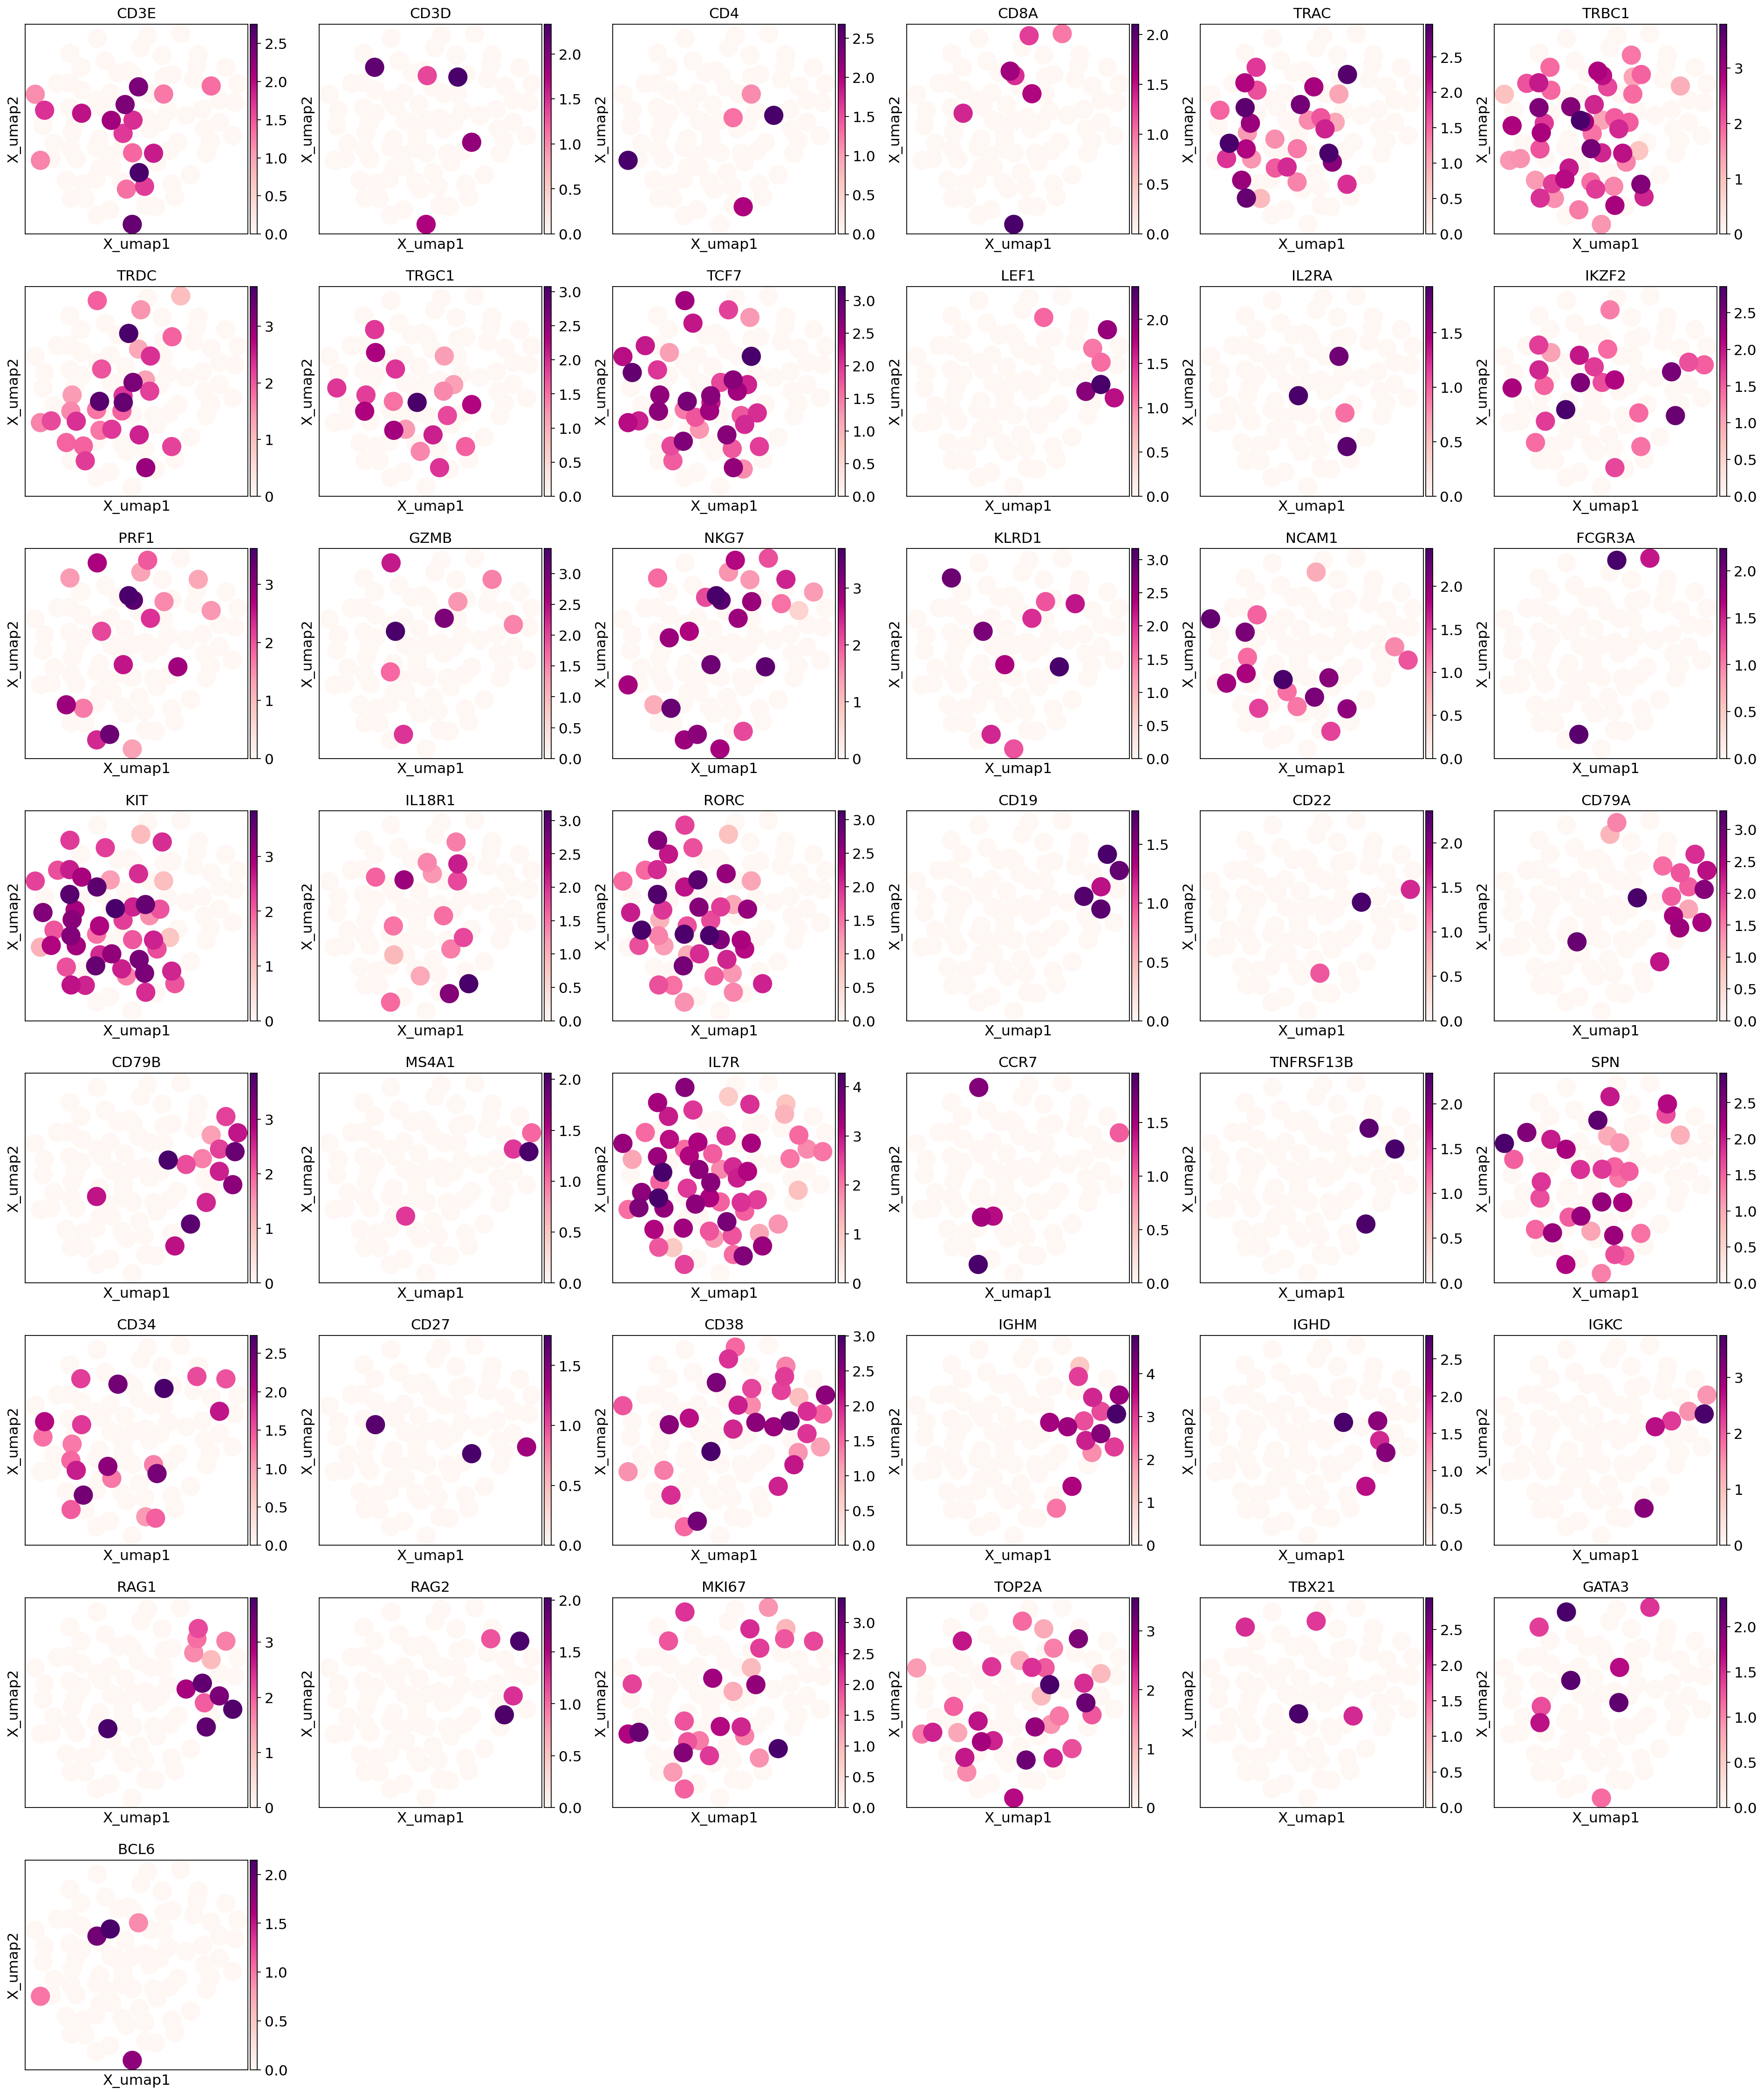

In [17]:
markers={
     'T cell': ['CD3E', 'CD3D','CD4', 'CD8A', 'CD8B','TRAC','TRBC1','TRDC','TRGC1'],
    'naive': ['TCF7', 'LEF1', 'SELL'],
    'CD4T_reg': ['FOXP3', 'CTLA4', 'IL2RA', 'IKZF2'],
    'cytotoxic': ['PRF1', 'GZMB', 'GZMH', 'NKG7'],
    'NK': ['KLRF1', 'KLRD1', 'NCAM1','FCGR3A','IFNG'],
    'ILC3': ['KIT', 'IL18R1','RORC','IL17A'],
    
    'B': ['CD19','CD20','CD22','CD79A', 'CD79B','MS4A1','IL7R',],
    '':['CCR7','TNFRSF13B',],
    'ProB':['KIT','SPN','CD34'],
    'B1':['CD27','CCR10','MS4A1','SPN'],
    'Plasma': ['CD27','CCR10','CD38','SDC1','JCAIN'],
    'Abs':['IGHM','IGHD', 'IGHG1','IGHG2', 'IGHG3','IGHG4', 'IGHA1','IGHE','IGLC1','IGKC'],
    'Gene editing': ['AICDA', 'RAG1','RAG2'],
    
    
    'Cycling':['MKI67','TOP2A'],

    'TFs': ['TBX21', 'GATA3', 'RORC', 'BCL6',],
}
genes = []
for g in markers.values():
    genes = genes + [x for x in g if (x in adata.var_names)&(x not in genes)]
for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.var_names]
sc.pl.embedding(adata,basis='X_umap',color=genes,
               ncols=6, wspace=0.2,cmap='RdPu',vmax='p99.7')

In [15]:
resolution_sel = 1

categories: 0, 1, 2, etc.
var_group_labels: CM, FB, EC, etc.


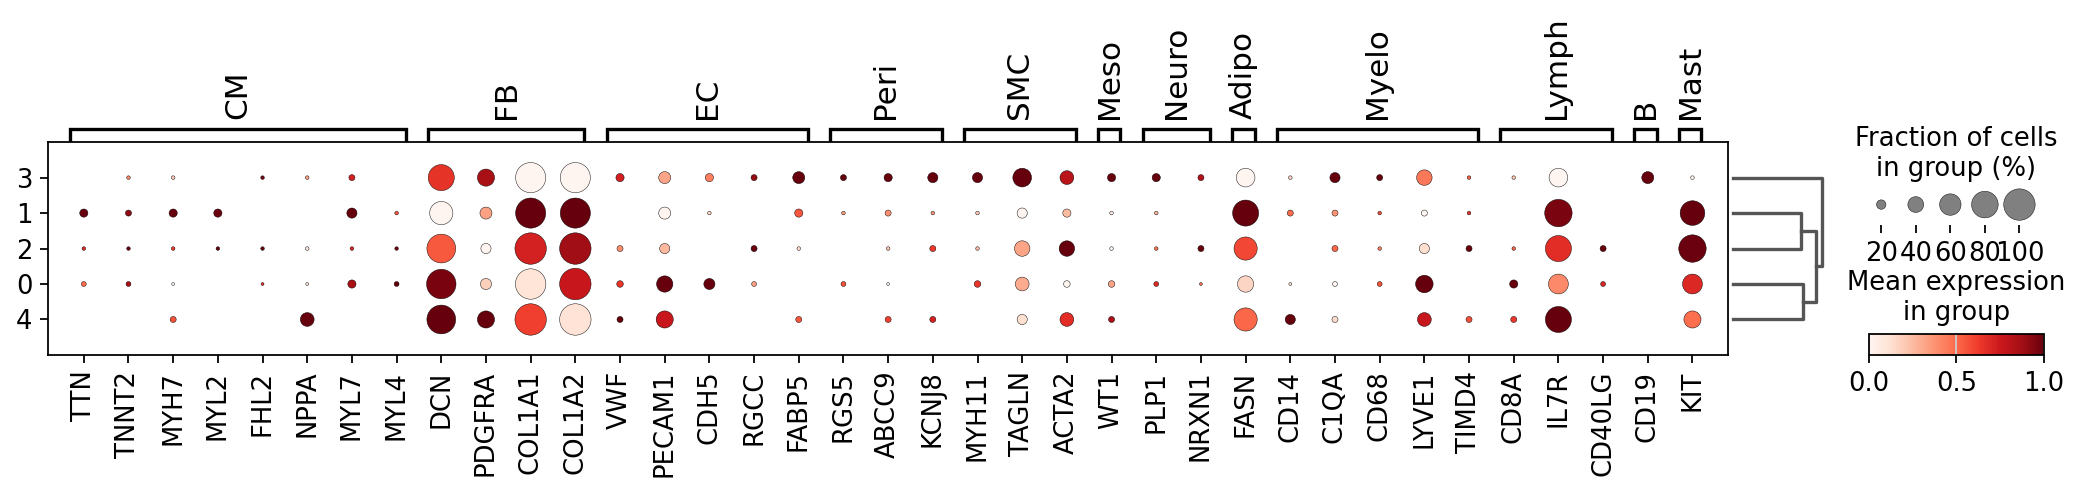

In [18]:
markers_others = {
    'CM': ['TTN', 'TNNT2','MYH6',
        'MYH7', 'MYL2', 'FHL2', # vCN
            'NPPA', 'MYL7', 'MYL4'], #aCM
    'FB': ['DCN', 'GCN', 'PDGFRA','COL1A1','COL1A2'],
    'EC': ['VWF', 'PECAM1', 'CDH5','RGCC', 'FABP5',],
    'Peri': ['RGS5', 'ABCC9', 'KCNJ8'],
    'SMC': ['MYH11', 'TAGLN', 'ACTA2'],
    'Meso': ['MSLN', 'WT1', 'BNC1'],
    'Neuro': ['PLP1', 'NRXN1', 'NRXN3','PRPH', 'NEFL', 'NEFM', 'NEFH', 'STMN2', 'SST', 'SLC10A4', 'SLC18A3', 'TH', 'NPY'],
    'Adipo': ['GPAM', 'FASN', 'LEP'],
    'Myelo': ['CD14', 'C1QA', 'CD68','LYVE1','TIMD4'],
    'Lymph': ['CD8A', 'IL7R', 'CD40LG'],
    'B': ['CD19','SDC1','IGHG1','IGHA1'],
    'Mast': ['KIT', 'CPA3'],
}

for key in markers_others.keys():
    markers_others[key]=[x for x in markers_others[key] if x in adata.var_names]

sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
sc.pl.dotplot(adata,
              markers_others, 
              groupby=f'leiden_{str(resolution_sel)}',
              dendrogram=True,
              standard_scale="var",
              color_map="Reds",
              swap_axes=False,
             )

categories: 0, 1, 2, etc.
var_group_labels: T cell, naive, CD4T_reg, etc.


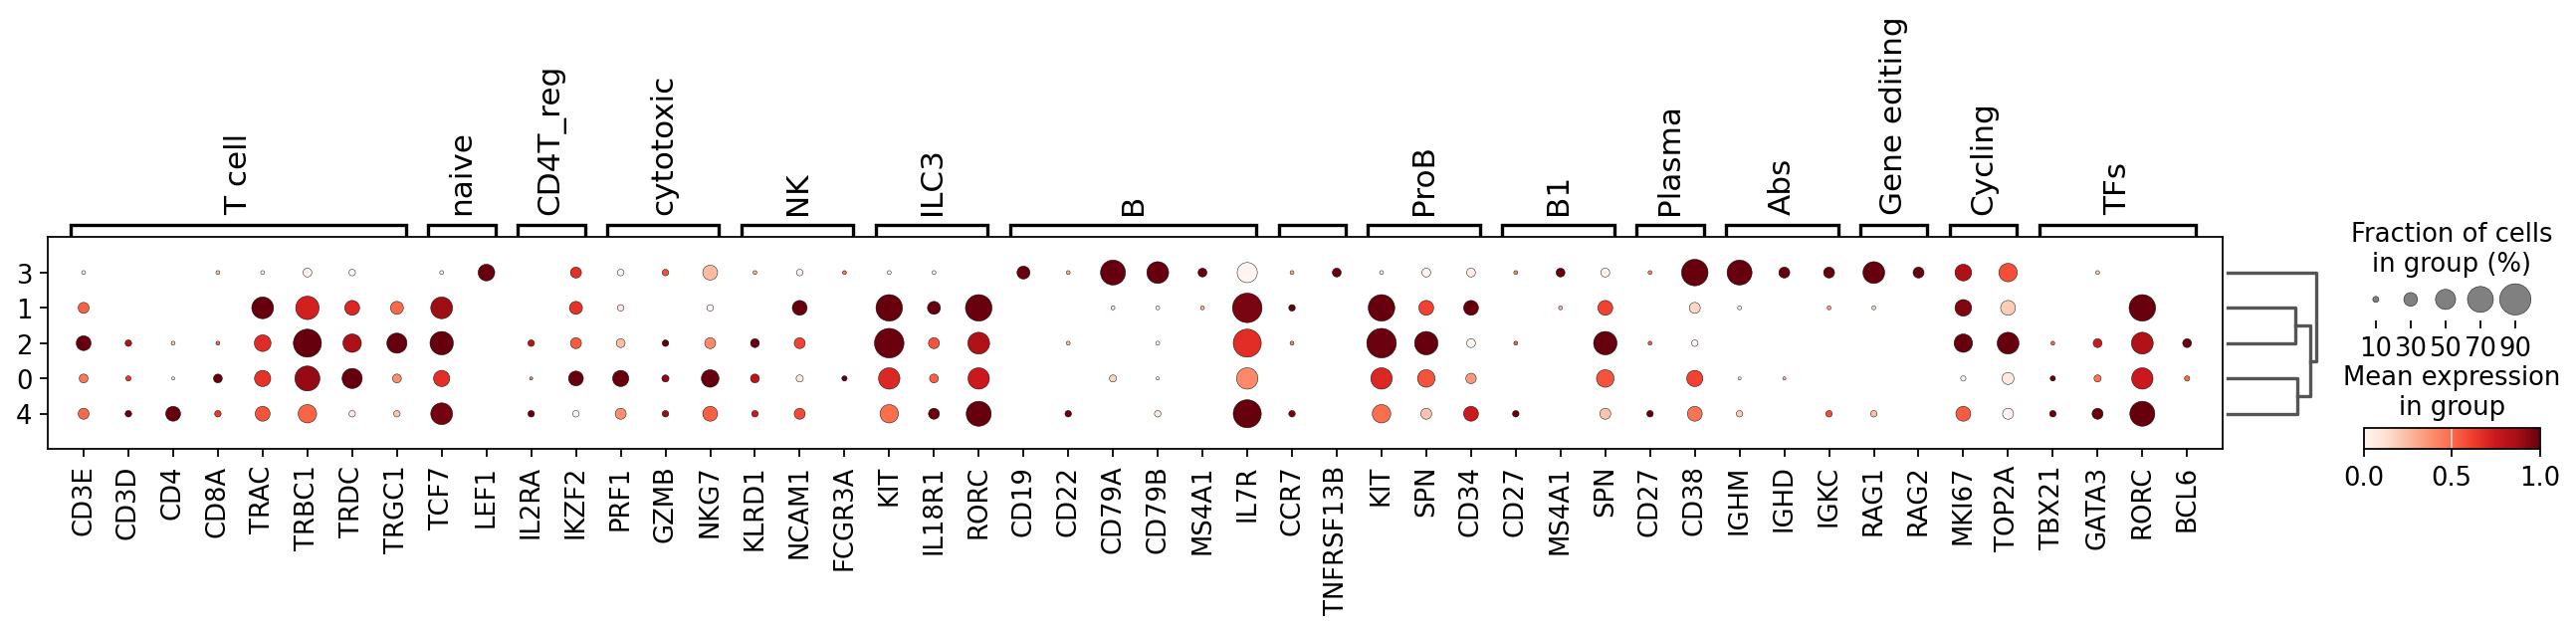

In [19]:
sc.tl.dendrogram(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.pl.dotplot(adata,
              var_names=markers,
              groupby=f'leiden_{str(resolution_sel)}',
              standard_scale='var',
              dendrogram=True
             )

[1.27187559 1.95641568 1.75023687 1.96760567 2.7810601 ]


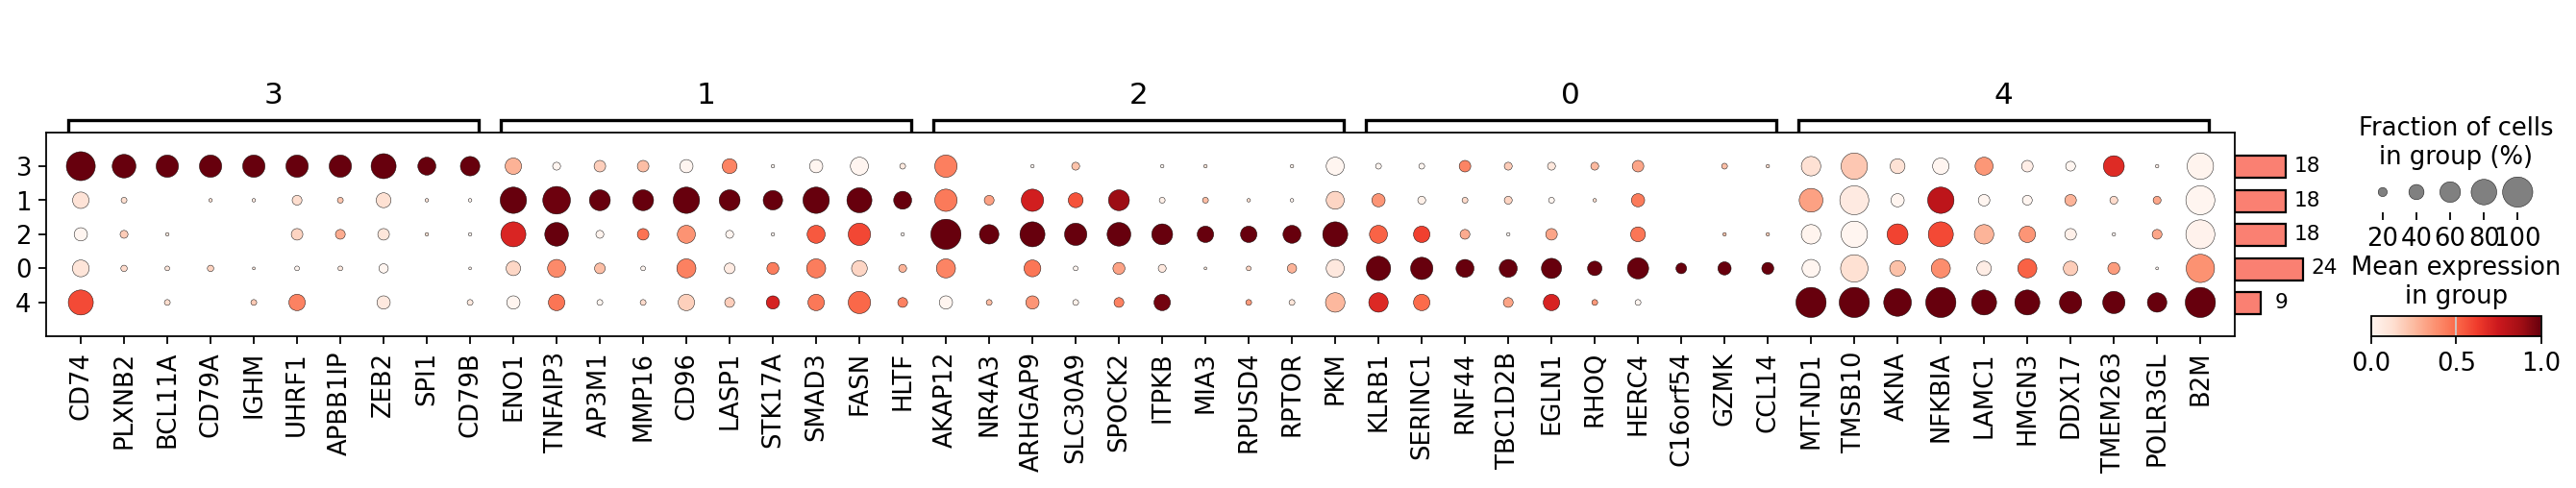

In [20]:
# DEG analysis
print(adata.X.data[:5])
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
dp=sc.pl.rank_genes_groups_dotplot(adata, dendrogram=True, standard_scale='var', return_fig=True)
dp.add_totals().show()

[1.27187559 1.95641568 1.75023687 1.96760567 2.7810601 ]


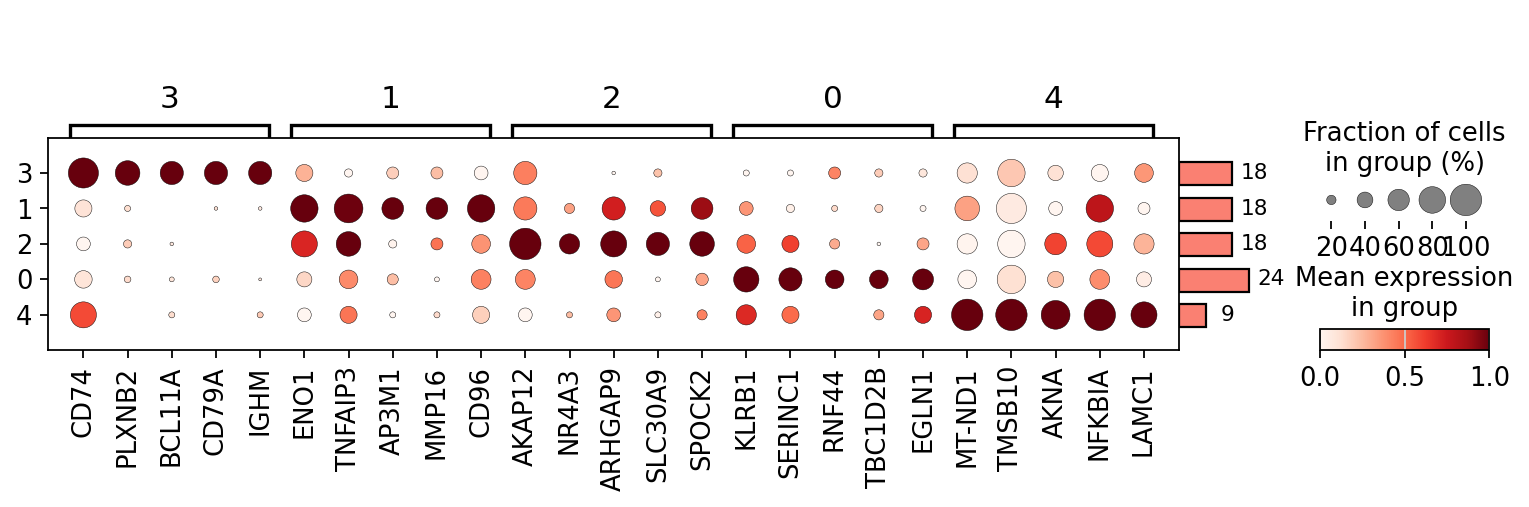

In [21]:
# DEG analysis
print(adata.X.data[:5])
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
dp=sc.pl.rank_genes_groups_dotplot(adata, dendrogram=True, standard_scale='var', return_fig=True, n_genes=5)
dp.add_totals().show()

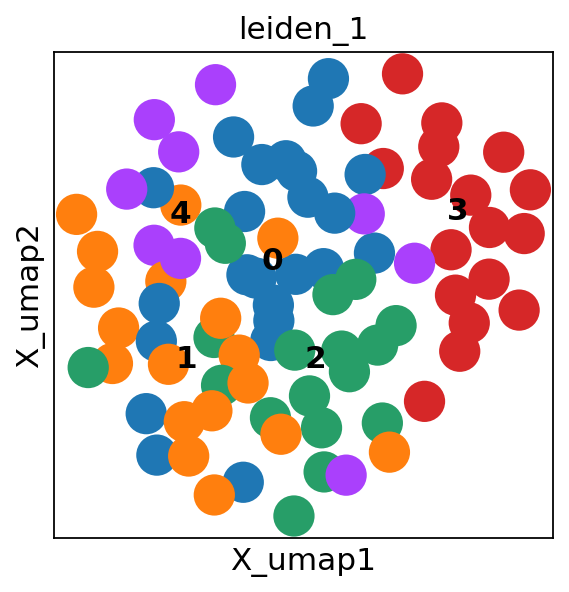

In [22]:
sc.pl.embedding(adata,basis='X_umap',
                color=f'leiden_{str(resolution_sel)}',
                wspace=0.3, legend_loc='on data')

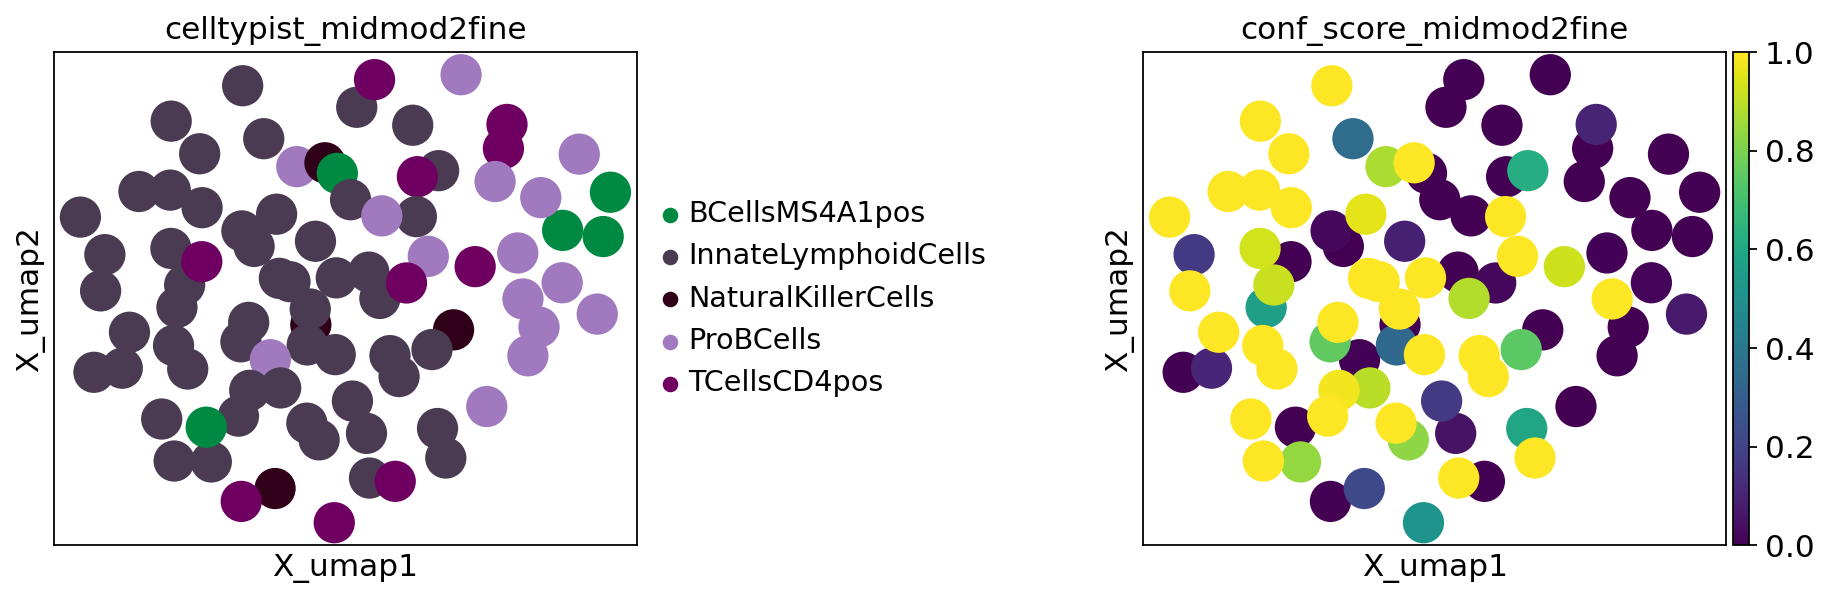

In [23]:
sc.pl.embedding(adata,basis='X_umap',
                color=['celltypist_midmod2fine', 'conf_score_midmod2fine'],
                wspace=0.7)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

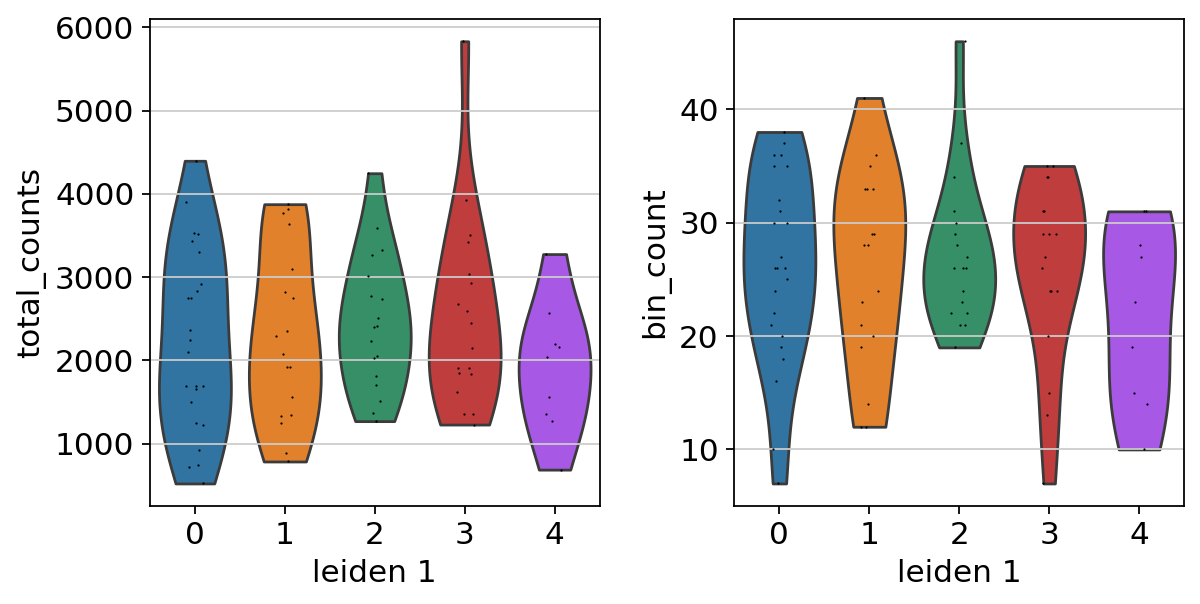

In [24]:
sc.pl.violin(adata,keys=['total_counts','bin_count'],groupby=f'leiden_{str(resolution_sel)}')

In [26]:
# annotate
adata.obs['fine_grain_manual'] = adata.obs[f'leiden_{str(resolution_sel)}'].copy()
adata.obs.replace({'fine_grain_manual':{
    '0':'InnateLymphoidCells',
    '1':'InnateLymphoidCells',
    '2':'InnateLymphoidCells',
    '3':'BCells',
    '4':'InnateLymphoidCells',
}},inplace=True)
adata.obs['fine_grain_manual'].value_counts()

fine_grain_manual
InnateLymphoidCells    69
BCells                 18
Name: count, dtype: int64

In [25]:
ad = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw_finegrain_updated.h5ad',backed='r')
ad[ad.obs['mid_grain']==celltype].obs['fine_grain'].value_counts()

fine_grain
TCellsCD4pos           5660
BCellsMS4A1pos         3470
NaturalKillerCells     2483
TCellsCD8pos           2297
TregsCD4pos            2096
BCells                 2058
InnateLymphoidCells    1719
ProBCells              1301
Name: count, dtype: int64

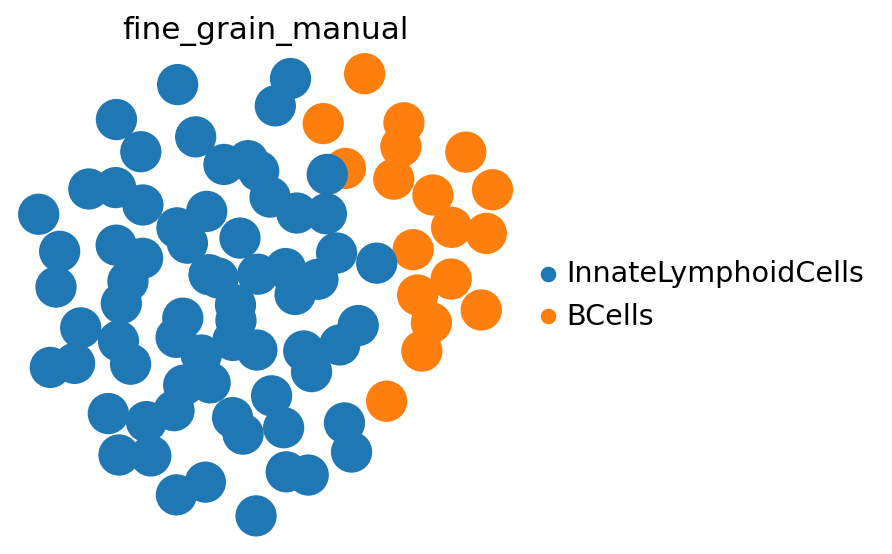

In [27]:
sc.pl.embedding(adata,basis='X_umap',
                color='fine_grain_manual',
                frameon=False,
                wspace=0.3)

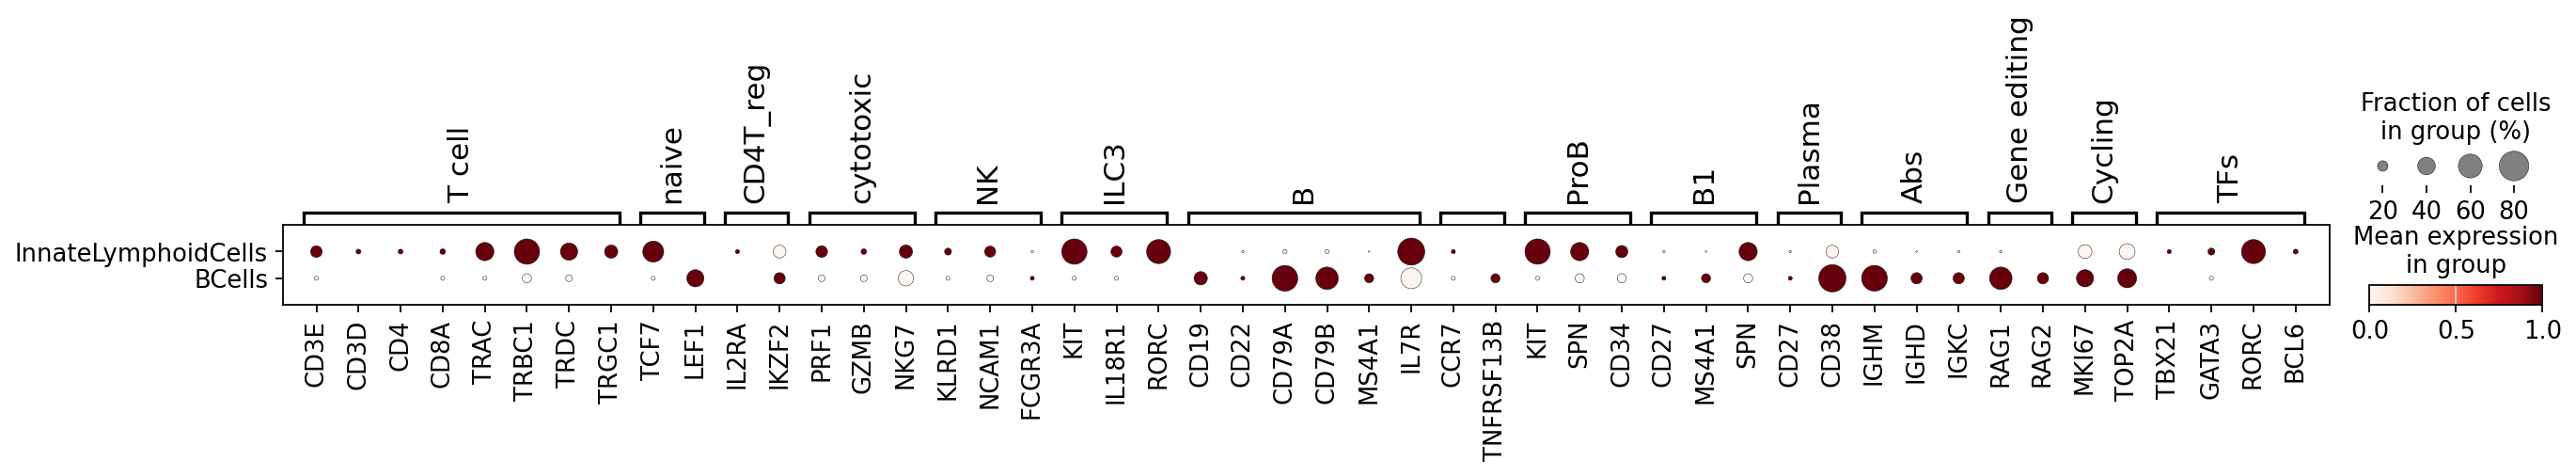

In [29]:
sc.tl.dendrogram(adata,groupby='fine_grain_manual')
sc.pl.dotplot(adata,
              var_names=markers,
              groupby='fine_grain_manual',
              standard_scale='var',
              dendrogram=True
             )

# Save

In [ ]:
# save
adata.write(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')
print(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')